Next Word Prediction Model - using RNN and LSTM.

Installing Required Libraries and Packges

In [1]:
import numpy as np 
import pandas as pd  
import tensorflow as tf
from colorama import Back, Fore
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from termcolor import colored, cprint

Dataset Information : Medium Articles Dataset
    Link: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset?select=medium_data.csv


In [2]:
df = pd.read_csv("medium_data.csv")
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


check shape of data

In [3]:
print("Number of records: ", df.shape[0])
print("Number of fields: ", df.shape[1])

Number of records:  6508
Number of fields:  10


Display titles of various articles and preprocess them

In [4]:
df["title"]

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [5]:
df["title"].isna().sum()

np.int64(0)

Data cleaning 

In [6]:
df["title"] = df["title"].apply(lambda x: x.replace("\xa0", " "))
df["title"] = df["title"].apply(lambda x: x.replace("\u200a", " "))

In [7]:
df["title"]

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

Tokenization

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(
    oov_token="<oov>"
)  # For those words which are not found in word_index
tokenizer.fit_on_texts(df["title"])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index["<oov>"])
print("Strong: ", tokenizer.word_index["strong"])
print("And: ", tokenizer.word_index["and"])
print("Consumption: ", tokenizer.word_index["consumption"])
print("------------")
print("Example how the data is stored :-\n", list(tokenizer.word_index.items())[:5])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237
------------
Example how the data is stored :-
 [('<oov>', 1), ('to', 2), ('the', 3), ('strong', 4), ('a', 5)]


In [11]:
input_sequences = []
for line in df["title"]:
    token_list = tokenizer.texts_to_sequences([line])[0]
  
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[: i + 1]
        input_sequences.append(n_gram_sequence)

print("This is What token list looks like :-", token_list)
cprint("------------", "yellow")
# print(input_sequences)
print("Total input sequences: ", len(input_sequences))
cprint("------------", "yellow")
print(list(tokenizer.word_index.items())[4])
print(list(tokenizer.word_index.items())[675])
print(list(tokenizer.word_index.items())[67])
print(list(tokenizer.word_index.items())[1])
print(list(tokenizer.word_index.items())[451])
print(list(tokenizer.word_index.items())[1517])
cprint("------------", "yellow")
print("This sentence is converted into the below sequence ::")
print(Back.RED, df["title"][0])
# print(len(list(tokenizer.word_index.items())))
input_sequences[:9]

This is What token list looks like :- [7, 2, 65, 5, 85, 56, 730, 550]
------------
Total input sequences:  48461
------------
('a', 5)
('beginner’s', 676)
('guide', 68)
('to', 2)
('word', 452)
('embedding', 1518)
------------
This sentence is converted into the below sequence ::
 A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model


[[5, 676],
 [5, 676, 68],
 [5, 676, 68, 2],
 [5, 676, 68, 2, 452],
 [5, 676, 68, 2, 452, 1518],
 [5, 676, 68, 2, 452, 1518, 14],
 [5, 676, 68, 2, 452, 1518, 14, 2455],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]]

In [12]:
token_list

[7, 2, 65, 5, 85, 56, 730, 550]

In [13]:
import pickle

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Make all titles with same length by using padding

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(x) for x in input_sequences])
# get the maximum length sequence
max_sequence_len

40

In [15]:
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre")
)
input_sequences[8]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,  676,   68,
          2,  452, 1518,   14, 2455, 3653,   99], dtype=int32)


Prepare features and labels

In [16]:
input_sequences[:, :]  # This is the original sequences

array([[  0,   0,   0, ...,   0,   5, 676],
       [  0,   0,   0, ...,   5, 676,  68],
       [  0,   0,   0, ..., 676,  68,   2],
       ...,
       [  0,   0,   0, ...,   5,  85,  56],
       [  0,   0,   0, ...,  85,  56, 730],
       [  0,   0,   0, ...,  56, 730, 550]], dtype=int32)

In [17]:
input_sequences[:, :-1] # This is the sequences leaving the last element

array([[  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ...,   0,   5, 676],
       [  0,   0,   0, ...,   5, 676,  68],
       ...,
       [  0,   0,   0, ...,  65,   5,  85],
       [  0,   0,   0, ...,   5,  85,  56],
       [  0,   0,   0, ...,  85,  56, 730]], dtype=int32)

In [18]:
input_sequences[:, -1]  # This is the last element which was omitted

array([676,  68,   2, ...,  56, 730, 550], dtype=int32)

In [19]:
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
print(xs[5])
print(labels[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14


In [20]:
cprint("Performing ONE-HOT ENCODING.....", "green")
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print("At row-5 and col-14 ==", ys[5][14])
pd.DataFrame(ys).head(6)

Performing ONE-HOT ENCODING.....
At row-5 and col-14 == 1.0


,0,1,2,3,4,5,6,7,8,9,...,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


RNN and Bidirectional LSTM Neural Network

In [21]:
# Build the model
model = Sequential([
    Embedding(total_words, 100),  
    Bidirectional(LSTM(150)),
    Dense(total_words, activation="softmax")
])

# Compile the model
adam = Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# Train the model
history = model.fit(xs, ys, epochs=2, verbose=1)

# Print model summary
model.summary()


Epoch 1/2
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.0989 - loss: 7.0394
Epoch 2/2
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.1756 - loss: 5.7413


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 100)        │       823,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300)            │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8238)           │     2,479,638 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,813,916 (41.25 MB)

 Trainable params: 3,604,638 (13.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,209,278 (27.50 MB)

Plotting model accuracy and loss 

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

Matplotlib is building the font cache; this may take a moment.


Graph of Accuracy

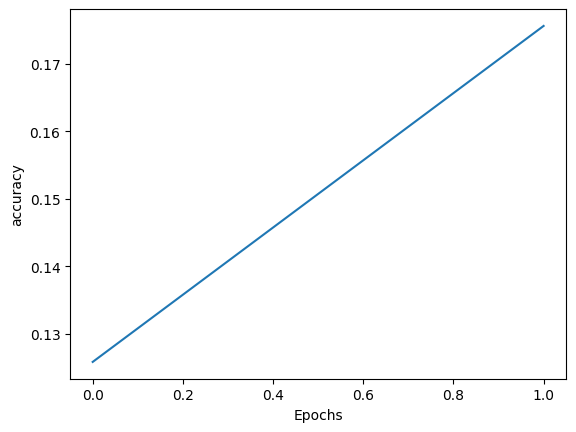

In [25]:
plot_graphs(history, "accuracy")

Graph of Loss

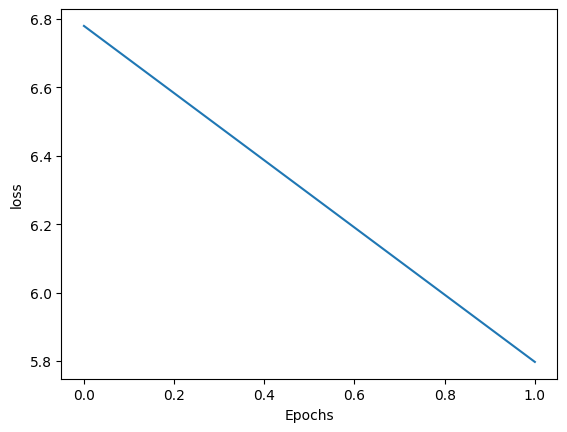

In [26]:
plot_graphs(history, "loss")

In [27]:
def output(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output("implementation of")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[84]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[84]
implementation of the future of the future


In [28]:
output("python for")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[3]
python for a data science and the


In [29]:
model.save("my_model.h5")



In [31]:
new_model = tf.keras.models.load_model("my_model.h5")
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 100)        │       823,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300)            │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8238)           │     2,479,638 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,604,640 (13.75 MB)

 Trainable params: 3,604,638 (13.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [32]:
def output_2(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        print(token_list)
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )

        predicted = np.argmax(new_model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output_2("implementation")

[485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
[6]
[485, 6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[3]
[485, 6, 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[84]
[485, 6, 3, 84]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[6]
[485, 6, 3, 84, 6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[3]
implementation of the future of the
